In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

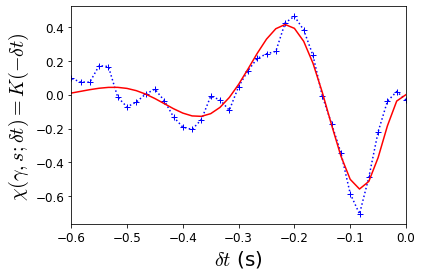

In [3]:
plt.rcParams["font.size"] = 12
os.chdir('..')
data_folder = os.getcwd()+"\\Experimental_Data_Example\\"  # Note that use absolute path on your computer instead.

dt = 1/60
cn = 9

annots = loadmat(data_folder+'OLED_Data\\merge_0224_cSTA_wf_3min_Q100', squeeze_me = True)
x = annots['bin_pos']
x = (x-np.mean(x))/np.std(x)

spike = annots['reconstruct_spikes'][cn-1]
rstate, _ = np.histogram(spike, np.arange(len(x)+1)*dt)

cSTA = np.correlate(x, rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt
OLEDtaxis = taxis

plt.plot(taxis, cSTA, 'b+:')
OLEDcSTA = cSTA

name_list = ['epsilon', 'gamma', 'omegastar', 'deltastar', 'tau_y', 'Dmp']
para_dict = {}
for l in range(len(name_list)):
    para_dict[name_list[l]] = np.zeros(60)
#-------------------------------------
para_dict['error'] = np.zeros(60)

epsilon = 10. #1/sec
gamma = 25.
omegastar = 30. 
deltastar = 0.
tau_y = 0.04
Dmp = 10.

popt,pcov = curve_fit(NGD2L_TK_AS, np.abs(taxis), cSTA, 
                      p0     =  [epsilon, gamma , omegastar, deltastar, tau_y, Dmp   ],
                      bounds = ([0      , 0     , 0        , -np.pi/2 , 0    , 0     ], 
                                [np.inf , np.inf, np.inf   ,  np.pi/2 , 0.1  , np.inf ] ))

for l in range(len(popt)):
    para_dict[name_list[l]][cn-1] = popt[l]
#     print(popt)
fit_cSTA = NGD2L_TK_AS(np.abs(taxis), *popt).copy()
OLEDfit_cSTA = fit_cSTA
# para_dict['error'][cn-1] = sum((fit_cSTA_list[cn-1]-cSTA_list[cn-1])**2)
plt.plot(taxis, fit_cSTA, 'r-')
plt.xlabel(r'$\delta t$ (s)', fontsize = 20)
plt.ylabel('$\chi(\gamma, s; \delta t) = K(-\delta t)$ ', fontsize = 20)

plt.xlim([-0.6,0])
fig = plt.gcf()
ax = plt.gca()

np.savez(data_folder+'\\OLED_Data\\fitNGD2LASpara.npz', para_dict=para_dict)

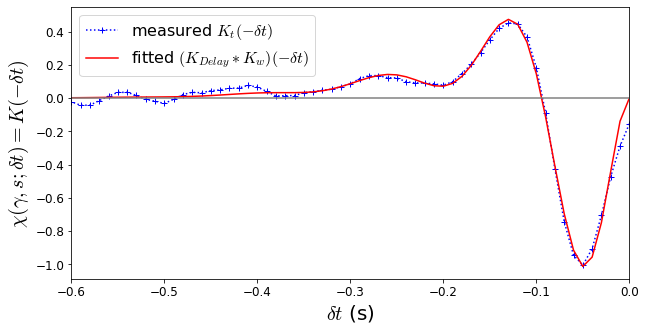

In [4]:
dt = 0.01
cn = 53

annots = loadmat(data_folder+'LED_Data\\20200408_cSTA_sort_unit2', squeeze_me = True)
sampling_rate = 20000
TimeStamps = annots['TimeStamps']
x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/2), mode='reflect') / dt
x = x[::int(sampling_rate*dt)]
x = x.astype(float)
x = (x -np.mean(x))/np.std(x)
T=np.arange(len(x))*dt+dt
rstate,_ = np.histogram(annots['Spikes'][cn-1]-TimeStamps[0], np.append(0,T))

cSTA = np.correlate(x, rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt
LEDtaxis = taxis

plt.plot(taxis, cSTA, 'b+:')
LEDcSTA = cSTA

name_list = ['epsilon', 'gamma', 'omegastar', 'deltastar', 'tau_y', 'Dmp']
para_dict = {}
for l in range(len(name_list)):
    para_dict[name_list[l]] = np.zeros(60)
#-------------------------------------
para_dict['error'] = np.zeros(60)

epsilon = 10. #1/sec
gamma = 25.
omegastar = 30. 
deltastar = 0.
tau_y = 0.04
Dmp = 10.

popt,pcov = curve_fit(NGD2L_TK_AS, np.abs(taxis), cSTA, 
                      p0     =  [epsilon, gamma , omegastar, deltastar, tau_y, Dmp   ],
                      bounds = ([0      , 0     , 0        , -np.pi/2 , 0    , 0     ], 
                                [np.inf , np.inf, np.inf   ,  np.pi/2 , 0.1  , np.inf ] ))

for l in range(len(popt)):
    para_dict[name_list[l]][cn] = popt[l]
#     print(popt)
fit_cSTA = NGD2L_TK_AS(np.abs(taxis), *popt).copy()
LEDfit_cSTA = fit_cSTA
# para_dict['error'][cn] = sum((fit_cSTA_list[cn]-cSTA_list[cn])**2)
plt.plot(taxis, fit_cSTA, 'r-')
plt.xlabel(r'$\delta t$ (s)', fontsize = 20)
plt.ylabel('$\chi(\gamma, s; \delta t) = K(-\delta t)$ ', fontsize = 20)

plt.axhline(0, c='gray')
plt.legend( (r'measured $K_t(-\delta t)$', r'fitted $(K_{Delay}*K_w)(-\delta t)$'), fontsize = 16 )
plt.xlim([-0.6,0])
fig = plt.gcf()
fig.set_size_inches(10, 5)